# US Equity Stock Calculator on Quantopian

In [1]:
# Importing libraries

from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.factors import SimpleMovingAverage

from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Stock Ticker to Analyze
stock_ticker = 'AAPL'

# Start Date of Analysis
start = '2014-01-01'

# End Date of Analysis / Present Date
end = '2019-03-25'

## Company Financial Data Pipelines

In [3]:
def company_reference_pipeline(stock = stock_ticker):
    
    # Company Name / Ticker
    ticker = morningstar.company_reference.primary_symbol.latest
    
    if stock == None:
        screen_filter = QTradableStocksUS()
    else:
        screen_filter = ticker.eq(stock_ticker)
    
    # Period Ending Date (Quarter End)
    earnings_date = morningstar.earnings_report.period_ending_date_earnings_reports.latest

    # Recent Trading Price
    price = USEquityPricing.close.latest

    # Shares Outstanding
    shares_outstanding = morningstar.valuation.shares_outstanding.latest

    # Market Cap
    market_cap = morningstar.valuation.market_cap.latest

    # P/E Ratio
    p_to_e = 1 / morningstar.valuation_ratios.earning_yield.latest

    # P/BV Ratio
    p_to_bv = price / morningstar.valuation_ratios.tangible_book_value_per_share.latest
    
    # Earnings / Share
    earnings = price / p_to_e
    
    # Earnings Multiple
    earnings_multiple = morningstar.valuation_ratios.earning_yield.latest
    
    # Tangible Book Value / Share
    book_value = morningstar.valuation_ratios.tangible_book_value_per_share.latest
    
    # Dividend / Share
    dividend = morningstar.earnings_report.dividend_per_share.latest
    
    
    return Pipeline(columns={
        'Ticker': ticker,
        'Quarter End': earnings_date,
        'Stock Price': price,
        'Shares Outstanding': shares_outstanding,
        'Market Cap': market_cap,
        'P/E': p_to_e,
        'P/BV': p_to_bv,
        'EPS': earnings,
        'Book Value/Share': book_value,
        'Dividend/Share': dividend,
        'Earnings Multiple': earnings_multiple,
        'Margin of Safety': 1 / p_to_bv
    }, screen = screen_filter)

company_ref = run_pipeline(company_reference_pipeline(), end, end)[['Ticker', 'Quarter End', 'Stock Price', 'Shares Outstanding', 'Market Cap', 'P/E', 'P/BV', 'EPS', 'Book Value/Share', 'Dividend/Share', 'Earnings Multiple', 'Margin of Safety']]
company_ref.index = company_ref.index.levels[0].strftime('%Y-%m-%d')

In [4]:
def balance_sheet_pipeline(stock = stock_ticker):
    
    # Company Name / Ticker
    ticker = morningstar.company_reference.primary_symbol.latest
    
    if stock == None:
        screen_filter = QTradableStocksUS()
    else:
        screen_filter = ticker.eq(stock_ticker)
        
    # Period Ending Date (Quarter End)
    earnings_date = morningstar.earnings_report.period_ending_date_earnings_reports.latest
    
    # Cash & Cash Equivalents
    cash = morningstar.balance_sheet.cash_and_cash_equivalents.latest
    
    # Total Assets
    total_assets = morningstar.balance_sheet.total_assets.latest

    # Total Debt
    total_liabilities = morningstar.balance_sheet.total_liabilities_net_minority_interest.latest

    # Total Shareholder Equity
    total_equity = morningstar.balance_sheet.total_equity.latest

    # Retained Earnings
    retained_earnings = morningstar.balance_sheet.retained_earnings.latest

    # Total Tangible Book Value
    book_value = morningstar.balance_sheet.tangible_book_value.latest
    book_value_per_share = morningstar.valuation_ratios.tangible_book_value_per_share.latest
    
    # Current Assets & Current Liabilities & Current Ratio
    current_assets = morningstar.balance_sheet.current_assets.latest
    current_liabilities = morningstar.balance_sheet.current_debt.latest
    current_ratio = current_assets / current_liabilities
    
    # Debt to Assets
    debt_to_assets = total_liabilities / total_assets
    
    # Debt to Equity
    debt_to_equity = total_liabilities / total_equity
    
    return Pipeline(columns = {
        'Quarter End': earnings_date,
        'Total Assets': total_assets,
        'Cash': cash,
        'Total Liabilities': total_liabilities,
        'Total Equity': total_equity,
        'Retained Earnings': retained_earnings,
        'Book Value': book_value,
        'Book Value/Share': book_value_per_share,
        'Current Ratio': current_ratio,
        'Debt to Assets': debt_to_assets,
        'Debt to Equity': debt_to_equity
        
    }, screen = screen_filter)

balance_sheet = run_pipeline(balance_sheet_pipeline(), start, end)[['Quarter End', 'Total Assets', 'Cash', 'Total Liabilities', 'Total Equity', 'Retained Earnings', 'Book Value', 'Book Value/Share', 'Current Ratio', 'Debt to Assets', 'Debt to Equity']]
balance_sheet.index = balance_sheet['Quarter End']
balance_sheet_quarterly = balance_sheet.groupby(balance_sheet.index).mean()[balance_sheet.groupby(balance_sheet.index).mean().index > start]

balance_sheet_annual = balance_sheet_quarterly[balance_sheet_quarterly.index.month > 10]

In [5]:
def income_statement_pipeline(stock = stock_ticker):
    
    # Company Name / Ticker
    ticker = morningstar.company_reference.primary_symbol.latest
    
    if stock == None:
        screen_filter = QTradableStocksUS()
    else:
        screen_filter = ticker.eq(stock_ticker)
        
    # Period Ending Date (Quarter End)
    earnings_date = morningstar.earnings_report.period_ending_date_earnings_reports.latest    

    # Revenue
    revenue = morningstar.income_statement.total_revenue.latest

    # Net Income
    net_income = morningstar.income_statement.normalized_income.latest

    # EPS
    eps = morningstar.earnings_report.normalized_diluted_eps.latest

    # COGS
    cogs = morningstar.income_statement.cost_of_revenue.latest

    # Operating Expense
    operating_expense = morningstar.income_statement.operating_expense.latest

    # Gross Margin
    gross_margin = (revenue - cogs) / revenue

    # Operating Margin
    operating_margin = (revenue - cogs - operating_expense) / revenue

    # Net Margin
    net_margin = net_income / revenue
    
    return Pipeline(columns = {
        'Quarter End': earnings_date,
        'Revenue': revenue,
        'Net Income': net_income,
        'Diluted EPS': eps,
        'COGS': cogs,
        'Operating Expense': operating_expense,
        'Gross Margin': gross_margin,
        'Operating Margin': operating_margin,
        'Net Margin': net_margin
    }, screen = screen_filter)

income_statement = run_pipeline(income_statement_pipeline(), start, end)[['Quarter End', 'Revenue', 'Net Income', 'Diluted EPS', 'COGS', 'Operating Expense', 'Gross Margin', 'Operating Margin', 'Net Margin']]
income_statement.index = income_statement['Quarter End']
income_statement_quarterly = income_statement.groupby(income_statement.index).mean()[income_statement.groupby(income_statement.index).mean().index > start]

income_statement_annual = income_statement_quarterly.groupby(income_statement_quarterly.index.year).sum().drop(['Gross Margin', 'Operating Margin', 'Net Margin'], axis=1)
income_statement_annual['Gross Margin'] = (income_statement_annual['Revenue'] - income_statement_annual['COGS']) / income_statement_annual['Revenue']
income_statement_annual['Operating Margin'] = (income_statement_annual['Revenue'] - income_statement_annual['COGS'] - income_statement_annual['Operating Expense']) / income_statement_annual['Revenue']
income_statement_annual['Net Margin'] = income_statement_annual['Net Income'] / income_statement_annual['Revenue']

In [6]:
def cash_flow_pipeline(stock = stock_ticker):
    
    # Company Name / Ticker
    ticker = morningstar.company_reference.primary_symbol.latest
    
    if stock == None:
        screen_filter = QTradableStocksUS()
    else:
        screen_filter = ticker.eq(stock_ticker)
        
    # Period Ending Date (Quarter End)
    earnings_date = morningstar.earnings_report.period_ending_date_earnings_reports.latest

    # Cash Flow from Operations
    operating_cf = morningstar.cash_flow_statement.operating_cash_flow.latest

    # CapEx
    capex = morningstar.cash_flow_statement.capital_expenditure.latest

    # Cash Flow from Investing Activities
    investing_cf = morningstar.cash_flow_statement.investing_cash_flow.latest

    # Free Cash Flow
    free_cf = morningstar.cash_flow_statement.free_cash_flow.latest

    # Cash Flow from Financing Activities
    financing_cf = morningstar.cash_flow_statement.financing_cash_flow.latest
    
    return Pipeline(columns = {
        'Quarter End': earnings_date,
        'Operating Cash Flow': operating_cf,
        'CapEx': capex,
        'Investing Cash Flow': investing_cf,
        'Free Cash Flow': free_cf,
        'Financing Cash Flow': financing_cf
    }, screen = screen_filter)

cash_flow = run_pipeline(cash_flow_pipeline(), start, end)[['Quarter End', 'Operating Cash Flow', 'CapEx', 'Investing Cash Flow', 'Free Cash Flow', 'Financing Cash Flow']]
cash_flow.index = cash_flow['Quarter End']
cash_flow_quarterly = cash_flow.groupby(cash_flow.index).mean()[cash_flow.groupby(cash_flow.index).mean().index > start]

cash_flow_annual = cash_flow_quarterly.groupby(cash_flow_quarterly.index.year).sum()

## Company Reference

In [7]:
company_ref

,Ticker,Quarter End,Stock Price,Shares Outstanding,Market Cap,P/E,P/BV,EPS,Book Value/Share,Dividend/Share,Earnings Multiple,Margin of Safety
2019-03-25,AAPL,2018-12-29,191.06,4.715280e+09,9.008542e+11,15.649452,7.641758,12.208734,25.0021,0.73,0.0639,0.13086


## Balance Sheet Quarterly

In [8]:
balance_sheet_quarterly

,Total Assets,Cash,Total Liabilities,Total Equity,Retained Earnings,Book Value,Book Value/Share,Current Ratio,Debt to Assets,Debt to Equity
Quarter End,,,,,,,,,,
2014-03-29,2.059890e+11,1.894900e+10,8.581000e+10,1.201790e+11,9.893400e+10,1.141960e+11,58.349396,233.579470,0.416576,0.714018
2014-06-28,2.225200e+11,1.297700e+10,1.015800e+11,1.209400e+11,9.871500e+10,1.147990e+11,19.171900,33.805473,0.456498,0.839921
2014-09-27,2.318390e+11,1.384400e+10,1.202920e+11,1.115470e+11,8.715200e+10,1.027890e+11,17.526300,10.864141,0.518860,1.078397
2014-12-27,2.618940e+11,1.947800e+10,1.385660e+11,1.233280e+11,9.717800e+10,1.143290e+11,19.628100,21.390869,0.529092,1.123557
2015-03-28,2.611940e+11,1.448900e+10,1.321880e+11,1.290060e+11,1.009200e+11,1.202340e+11,20.870200,17.870755,0.506091,1.024666
2015-06-27,2.731510e+11,1.531900e+10,1.474740e+11,1.256770e+11,9.825200e+10,1.168540e+11,20.490900,10.137591,0.539899,1.173437
2015-09-26,2.904790e+11,2.112000e+10,1.711240e+11,1.193550e+11,9.228400e+10,1.103460e+11,19.803076,8.126011,0.589110,1.433740
2015-12-26,2.932840e+11,1.668900e+10,1.650170e+11,1.282670e+11,1.014940e+11,1.191410e+11,21.487800,7.810124,0.562653,1.286512
2016-03-25,3.052770e+11,2.151400e+10,1.748200e+11,1.304570e+11,1.020210e+11,1.213650e+11,22.157300,8.343685,0.572660,1.340058


## Balance Sheet Annual

In [9]:
balance_sheet_annual.index.names = ['Date']
balance_sheet_annual

,Total Assets,Cash,Total Liabilities,Total Equity,Retained Earnings,Book Value,Book Value/Share,Current Ratio,Debt to Assets,Debt to Equity
Date,,,,,,,,,,
2014-12-27,2.618940e+11,1.947800e+10,1.385660e+11,1.233280e+11,9.717800e+10,1.143290e+11,19.628100,21.390869,0.529092,1.123557
2015-12-26,2.932840e+11,1.668900e+10,1.650170e+11,1.282670e+11,1.014940e+11,1.191410e+11,21.487800,7.810124,0.562653,1.286512
2016-12-31,3.311410e+11,1.637100e+10,1.987510e+11,1.323900e+11,1.000010e+11,1.241190e+11,23.646043,7.385077,0.600201,1.501254
2017-12-30,4.067940e+11,2.749100e+10,2.665950e+11,1.401990e+11,1.045930e+11,1.321610e+11,26.042844,7.782769,0.655356,1.901547
2018-12-29,3.737190e+11,4.477100e+10,2.558270e+11,1.178920e+11,8.051000e+10,1.178920e+11,25.002100,6.477531,0.684544,2.170012


## Income Statement Quarterly

In [10]:
income_statement_quarterly

,Revenue,Net Income,Diluted EPS,COGS,Operating Expense,Gross Margin,Operating Margin,Net Margin
Quarter End,,,,,,,,
2014-03-29,4.564600e+10,1.022300e+10,5.320277,2.769900e+10,4.354000e+09,0.393178,0.297792,0.223963
2014-06-28,3.743200e+10,7.748000e+09,1.280299,2.269700e+10,4.453000e+09,0.393647,0.274685,0.206989
2014-09-27,4.212300e+10,8.467000e+09,1.417764,2.611400e+10,4.844000e+09,0.380054,0.265057,0.201007
2014-12-27,7.459900e+10,1.802400e+10,3.064366,4.485800e+10,5.495000e+09,0.398678,0.325018,0.241612
2015-03-28,5.801000e+10,1.356900e+10,2.325506,3.435400e+10,5.378000e+09,0.407792,0.315084,0.233908
2015-06-27,4.960500e+10,1.067700e+10,1.849440,2.992400e+10,5.598000e+09,0.396754,0.283903,0.215240
2015-09-26,5.150100e+10,1.112400e+10,1.957584,3.095300e+10,5.925000e+09,0.398983,0.283936,0.215996
2015-12-26,7.587200e+10,1.836100e+10,3.282192,4.544900e+10,6.252000e+09,0.400978,0.318576,0.242000
2016-03-25,5.055700e+10,1.051600e+10,1.898661,3.063600e+10,5.934000e+09,0.394031,0.276658,0.208003


## Income Statement Annual

In [11]:
income_statement_annual.index = balance_sheet_annual.index
income_statement_annual.index.names = ['Date']
income_statement_annual

,Revenue,Net Income,Diluted EPS,COGS,Operating Expense,Gross Margin,Operating Margin,Net Margin
Date,,,,,,,,
2014-12-27,1.998000e+11,4.446200e+10,11.082706,1.213680e+11,1.914600e+10,0.392553,0.296727,0.222533
2015-12-26,2.349880e+11,5.373100e+10,9.414722,1.406800e+11,2.315300e+10,0.401331,0.302803,0.228654
2016-12-31,2.181180e+11,4.521700e+10,8.368661,1.341020e+11,2.480400e+10,0.385186,0.271468,0.207305
2017-12-30,2.391760e+11,5.052500e+10,9.730000,1.472540e+11,2.766300e+10,0.384328,0.268668,0.211246
2018-12-29,2.616120e+11,5.943100e+10,12.170000,1.616540e+11,3.198800e+10,0.382085,0.259812,0.227172


## Cash Flow Quarterly

In [12]:
cash_flow_quarterly

,Operating Cash Flow,CapEx,Investing Cash Flow,Free Cash Flow,Financing Cash Flow
Quarter End,,,,,
2014-03-29,1.353800e+10,-1.486000e+09,1.174100e+10,1.205200e+10,-2.040700e+10
2014-06-28,1.025500e+10,-2.431000e+09,-2.221400e+10,7.824000e+09,5.987000e+09
2014-09-27,1.325000e+10,-3.852000e+09,2.997000e+09,9.398000e+09,-1.538000e+10
2014-12-27,3.372200e+10,-3.265000e+09,-2.116500e+10,3.045700e+10,-6.923000e+09
2015-03-28,1.908100e+10,-2.476000e+09,-2.233100e+10,1.660500e+10,-1.739000e+09
2015-06-27,1.498800e+10,-2.089000e+09,-1.140300e+10,1.289900e+10,-2.755000e+09
2015-09-26,1.347500e+10,-3.658000e+09,-1.375000e+09,9.817000e+09,-6.299000e+09
2015-12-26,2.746300e+10,-4.006000e+09,-2.045000e+10,2.345700e+10,-1.144400e+10
2016-03-25,1.160100e+10,-2.599000e+09,-1.366000e+10,9.002000e+09,6.884000e+09


## Cash Flow Annual

In [13]:
cash_flow_annual.index = balance_sheet_annual.index
cash_flow_annual.index.names = ['Date']
cash_flow_annual

,Operating Cash Flow,CapEx,Investing Cash Flow,Free Cash Flow,Financing Cash Flow
Date,,,,,
2014-12-27,7.076500e+10,-1.103400e+10,-2.864100e+10,5.973100e+10,-3.672300e+10
2015-12-26,7.500700e+10,-1.222900e+10,-5.555900e+10,6.277800e+10,-2.223700e+10
2016-12-31,6.541700e+10,-1.296200e+10,-4.464900e+10,5.245500e+10,-2.108600e+10
2017-12-30,6.483500e+10,-1.233900e+10,-4.091400e+10,5.249600e+10,-1.280100e+10
2018-12-29,7.583100e+10,-1.370400e+10,3.550000e+10,6.212700e+10,-9.405100e+10


## Margin of Safety and Earnings

In [14]:
valuation_metrics = company_ref[['Stock Price', 'P/E', 'P/BV', 'EPS', 'Book Value/Share', 'Earnings Multiple','Margin of Safety']]
valuation_metrics

,Stock Price,P/E,P/BV,EPS,Book Value/Share,Earnings Multiple,Margin of Safety
2019-03-25,191.06,15.649452,7.641758,12.208734,25.0021,0.0639,0.13086


## Return Metrics (Return on Assets & Return on Equity)

In [15]:
return_metrics = pd.DataFrame()
roa = income_statement_annual['Net Income'] / balance_sheet_annual['Total Assets']
roe = income_statement_annual['Net Income'] / balance_sheet_annual['Total Equity']
return_metrics['Return on Assets'] = roa
return_metrics['Return on Equity'] = roe

In [16]:
return_metrics

,Return on Assets,Return on Equity
Date,,
2014-12-27,0.169771,0.360518
2015-12-26,0.183205,0.418900
2016-12-31,0.136549,0.341544
2017-12-30,0.124203,0.360381
2018-12-29,0.159026,0.504114


## Liquidity and Solvency Metrics

In [17]:
# Current Ratio , Debt to Assets, Debt to Equity
liquidity_metrics = balance_sheet_annual[['Current Ratio', 'Debt to Assets', 'Debt to Equity']]
liquidity_metrics

,Current Ratio,Debt to Assets,Debt to Equity
Date,,,
2014-12-27,21.390869,0.529092,1.123557
2015-12-26,7.810124,0.562653,1.286512
2016-12-31,7.385077,0.600201,1.501254
2017-12-30,7.782769,0.655356,1.901547
2018-12-29,6.477531,0.684544,2.170012


## Cash on Hand

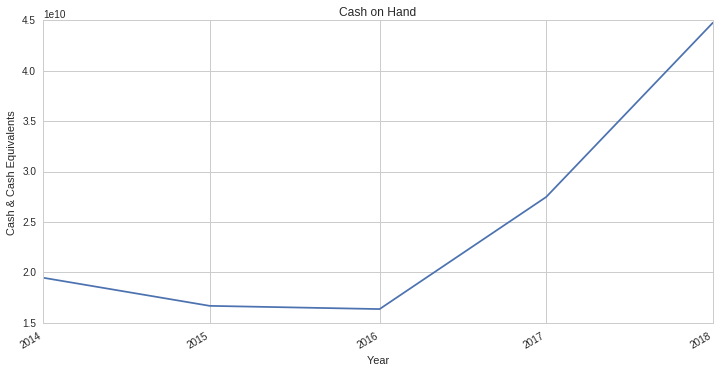

In [18]:
balance_sheet_annual['Cash'].plot(figsize=(12,6), xticks=balance_sheet_annual.index)
plt.title('Cash on Hand')
plt.ylabel('Cash & Cash Equivalents')
plt.xlabel('Year')

## Company Margins

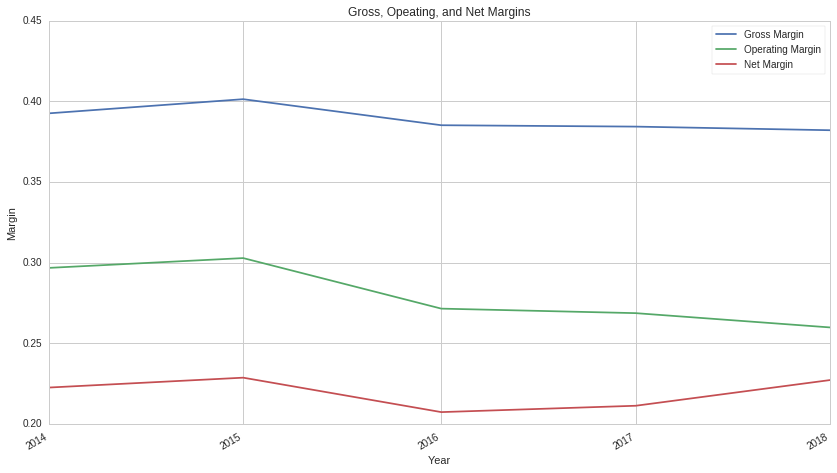

In [19]:
# Plots the companys' margins over the years
income_statement_annual['Gross Margin'].plot(xticks=income_statement_annual.index)
income_statement_annual['Operating Margin'].plot()
income_statement_annual['Net Margin'].plot()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Margin')
plt.title('Gross, Opeating, and Net Margins')

## Growth Metrics

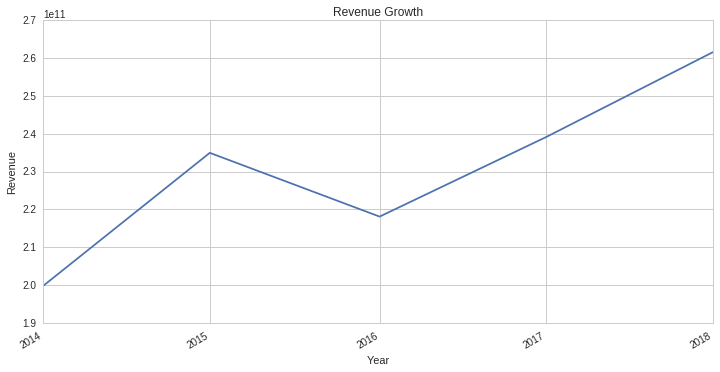

In [20]:
# Growth in Revenue
income_statement_annual['Revenue'].plot(figsize=(12,6), xticks=income_statement_annual.index)
plt.title('Revenue Growth')
plt.ylabel('Revenue')
plt.xlabel('Year')

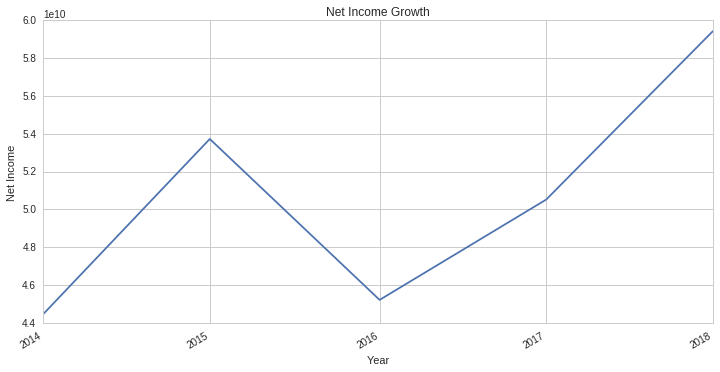

In [21]:
# Growth in Net Income
income_statement_annual['Net Income'].plot(figsize=(12,6), xticks=income_statement_annual.index)
plt.title('Net Income Growth')
plt.ylabel('Net Income')
plt.xlabel('Year')

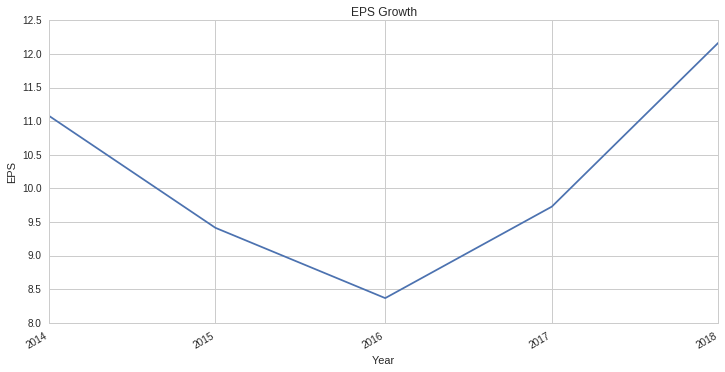

In [22]:
# Growth in EPS
income_statement_annual['Diluted EPS'].plot(figsize=(12,6), xticks=income_statement_annual.index)
plt.title('EPS Growth')
plt.ylabel('EPS')
plt.xlabel('Year')

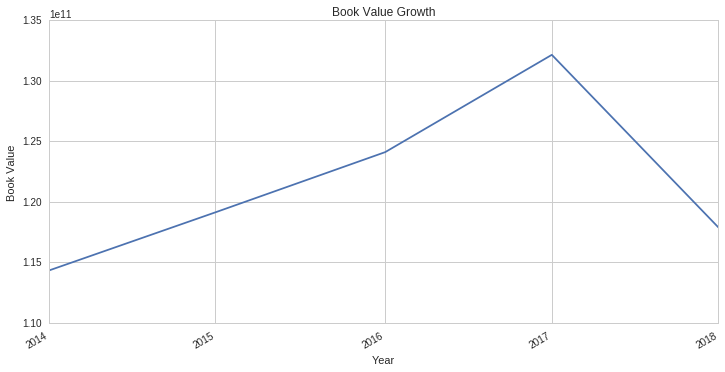

In [23]:
# Growth in Book Value
balance_sheet_annual['Book Value'].plot(figsize=(12,6), xticks=balance_sheet_annual.index)
plt.title('Book Value Growth')
plt.ylabel('Book Value')
plt.xlabel('Year')

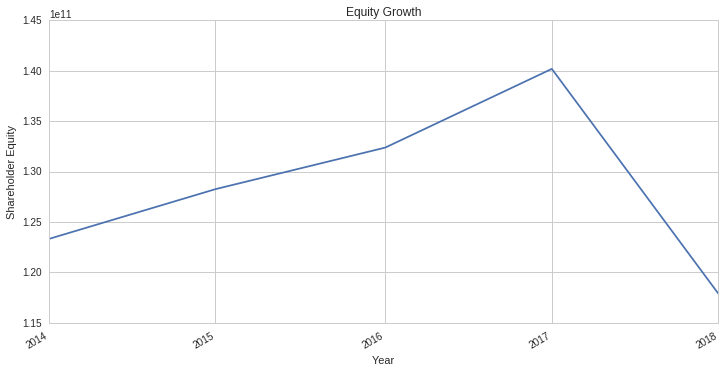

In [24]:
# Growth in Equity
balance_sheet_annual['Total Equity'].plot(figsize=(12,6), xticks=balance_sheet_annual.index)
plt.title('Equity Growth')
plt.ylabel('Shareholder Equity')
plt.xlabel('Year')

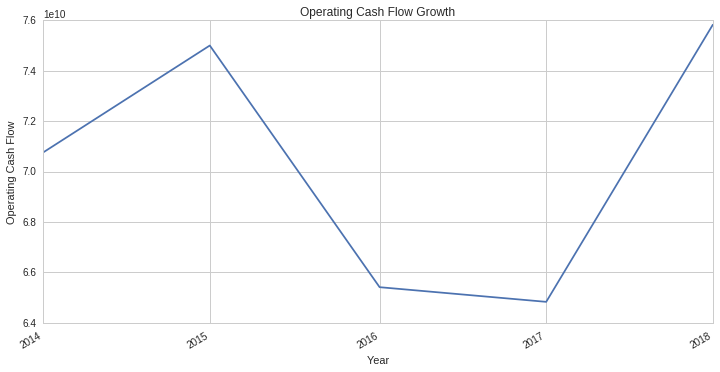

In [25]:
# Growth in Operating Cash Flow
cash_flow_annual['Operating Cash Flow'].plot(figsize=(12,6), xticks=cash_flow_annual.index)
plt.title('Operating Cash Flow Growth')
plt.ylabel('Operating Cash Flow')
plt.xlabel('Year')

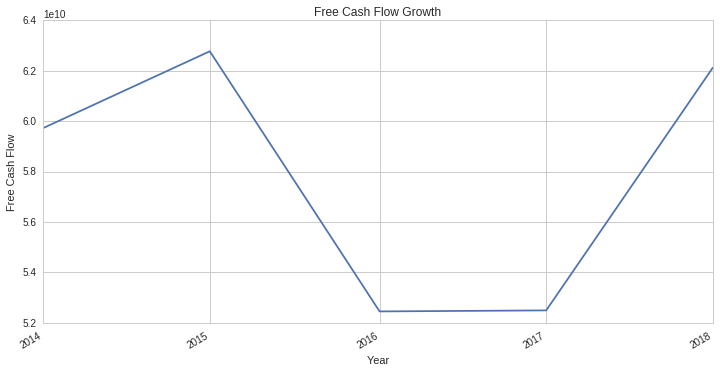

In [26]:
# Growth in Free Cash Flow
cash_flow_annual['Free Cash Flow'].plot(figsize=(12,6), xticks=cash_flow_annual.index)
plt.title('Free Cash Flow Growth')
plt.ylabel('Free Cash Flow')
plt.xlabel('Year')

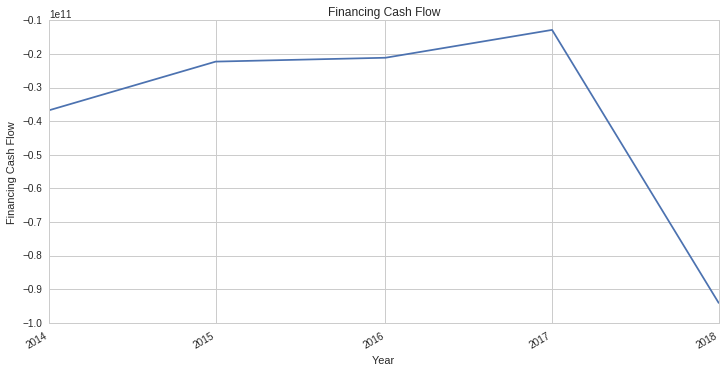

In [27]:
# Financing Cash Flow
cash_flow_annual['Financing Cash Flow'].plot(figsize=(12,6), xticks=cash_flow_annual.index)
plt.title('Financing Cash Flow')
plt.ylabel('Financing Cash Flow')
plt.xlabel('Year')

## Normalized Plots (Only Valid for Positive Values)

In [28]:
# Financial Position and Profitability Data
data = pd.DataFrame()
data[['Cash', 'Total Assets', 'Total Liabilities', 'Total Equity', 'Book Value']] = balance_sheet_annual[['Cash', 'Total Assets', 'Total Liabilities', 'Total Equity', 'Book Value']]
data[['Revenue', 'Net Income', 'Diluted EPS']] = income_statement_annual[['Revenue', 'Net Income', 'Diluted EPS']]
data[['Operating Cash Flow', 'Free Cash Flow']] = cash_flow_annual[['Operating Cash Flow', 'Free Cash Flow']]


In [29]:
data

,Cash,Total Assets,Total Liabilities,Total Equity,Book Value,Revenue,Net Income,Diluted EPS,Operating Cash Flow,Free Cash Flow
Date,,,,,,,,,,
2014-12-27,1.947800e+10,2.618940e+11,1.385660e+11,1.233280e+11,1.143290e+11,1.998000e+11,4.446200e+10,11.082706,7.076500e+10,5.973100e+10
2015-12-26,1.668900e+10,2.932840e+11,1.650170e+11,1.282670e+11,1.191410e+11,2.349880e+11,5.373100e+10,9.414722,7.500700e+10,6.277800e+10
2016-12-31,1.637100e+10,3.311410e+11,1.987510e+11,1.323900e+11,1.241190e+11,2.181180e+11,4.521700e+10,8.368661,6.541700e+10,5.245500e+10
2017-12-30,2.749100e+10,4.067940e+11,2.665950e+11,1.401990e+11,1.321610e+11,2.391760e+11,5.052500e+10,9.730000,6.483500e+10,5.249600e+10
2018-12-29,4.477100e+10,3.737190e+11,2.558270e+11,1.178920e+11,1.178920e+11,2.616120e+11,5.943100e+10,12.170000,7.583100e+10,6.212700e+10


In [30]:
# Normalizing the above Data taking the base year as 2014
normalized_data = data / data.iloc[0]
normalized_data

,Cash,Total Assets,Total Liabilities,Total Equity,Book Value,Revenue,Net Income,Diluted EPS,Operating Cash Flow,Free Cash Flow
Date,,,,,,,,,,
2014-12-27,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2015-12-26,0.856813,1.119858,1.190891,1.040048,1.042089,1.176116,1.208470,0.849497,1.059945,1.051012
2016-12-31,0.840487,1.264409,1.434342,1.073479,1.085630,1.091682,1.016981,0.755110,0.924426,0.878187
2017-12-30,1.411387,1.553277,1.923957,1.136798,1.155971,1.197077,1.136364,0.877944,0.916202,0.878874
2018-12-29,2.298542,1.426986,1.846247,0.955922,1.031164,1.309369,1.336670,1.098107,1.071589,1.040113


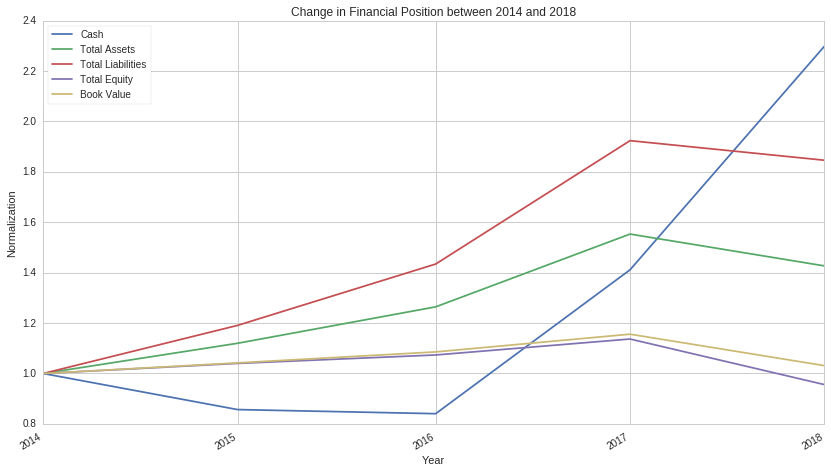

In [31]:
# Plotting the change in financial position of the data above
normalized_data.iloc[:,0:5].plot(xticks=normalized_data.index)
plt.title('Change in Financial Position between 2014 and 2018')
plt.xlabel('Year')
plt.ylabel('Normalization')

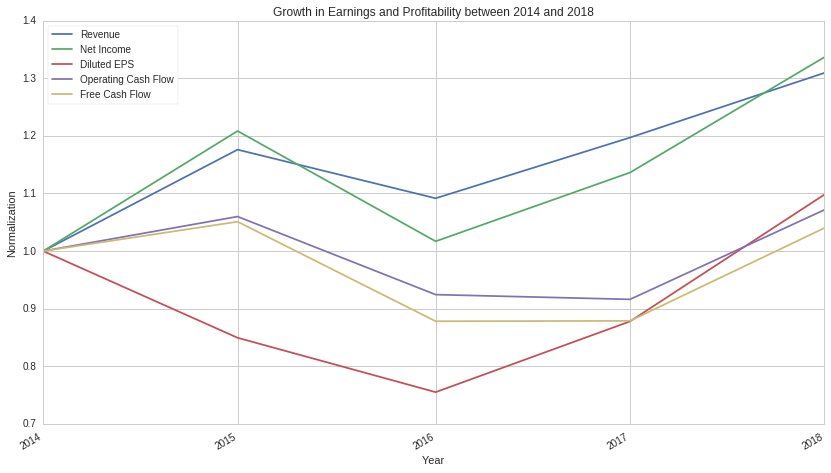

In [32]:
# Plotting the growth in earnings and profitability of above data
normalized_data.iloc[:,5:].plot(xticks=normalized_data.index)
plt.title('Growth in Earnings and Profitability between 2014 and 2018')
plt.xlabel('Year')
plt.ylabel('Normalization')